## **Dependencias**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchinfo
from torchvision import transforms, models, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm.autonotebook import tqdm
from collections import Counter

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

/var/folders/_r/zz5k5z950ds_76tdlnx3l4780000gn/T/ipykernel_35922/3695414816.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


## **Cargar datos**

In [ ]:
# Definir dispositivo donde se harán las operaciones
device = torch.device('mps' if torch.mps.is_available() else 'cpu')
device

device(type='mps')

In [ ]:
# Transformación para cargar datos
image_size = (28, 28)
data_transform = transforms.Compose(
    [
        transforms.Resize(size=image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=0.5, std=0.5)
    ]
)

train_dataset = datasets.FashionMNIST(
    root='./data',
    train=True,
    transform=data_transform,
    download=True
)

test_dataset = datasets.FashionMNIST(
    root='./data',
    train=False,
    transform=data_transform,
    download=True
)

# Igualar el tamaño de datos de validación al de prueba
val_size = len(test_dataset)
train_size = len(train_dataset) - val_size

# Separar dataset en entrenamiento y validación
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Definir constante con el número de clases
N_CLASSES = len(test_dataset.classes)

## **Utilidad**

In [ ]:
class AugmentDataset(Dataset):
    def __init__(self, dataset: Dataset, transform: transforms.Compose, n: int = 5):
        self.dataset = dataset       # Base de datos inicial
        self.transform = transform   # Función de transformaciones
        self.n = n                   # Cantidad de transformaciones por imagen

    def __len__(self):
        return len(self.dataset) * (self.n + 1)

    def __getitem__(self, index):
        original_idx = index // (self.n + 1)
        image, label = self.dataset[original_idx]

        if index % (self.n + 1) == 0:
            return image, label

        return self.transform(image), label

In [ ]:
def show_class_images(data_loader: DataLoader, n_images: int = 10):
    counter_images = Counter()
    plt.figure(figsize=(15, 15))

    examples = iter(data_loader)
    example_data, example_targets = next(examples)

    for data, target in zip(example_data.tolist(), example_targets.tolist()):
        if sum(counter_images.values()) == N_CLASSES * n_images:
            break

        if counter_images[target] == n_images:
            continue

        counter_images[target] += 1
        idx = counter_images[target] + n_images * target

        plt.subplot(N_CLASSES, n_images, idx)
        plt.imshow(data[0], cmap='gray')

    plt.show()

In [ ]:
def train(model, data_loader: DataLoader, loss_fn, optimizer):
    model.train()
    train_loss = 0
    n_correct = 0
    n_samples = 0

    for data, labels in tqdm(data_loader, total=len(data_loader), leave=False):
        data = data.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(data)
        loss = loss_fn(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)

        _, predicted = torch.max(outputs.data, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

    train_acc = 100.0 * n_correct / n_samples
    train_loss /= n_samples

    return train_acc, train_loss

In [ ]:
def test(model, data_loader: DataLoader, loss_fn):
    model.eval()
    test_loss = 0
    n_correct = 0
    n_samples = 0

    with torch.inference_mode():
        for data, labels in tqdm(data_loader, total=len(data_loader), leave=False):
            data = data.to(device)
            labels = labels.to(device)

            # Forward
            outputs = model(data).to(device)
            loss = loss_fn(outputs, labels)

            test_loss += loss.item() * data.size(0)

            _, predicted = torch.max(outputs.data, 1)
            n_samples += labels.size(0)
            n_correct += (predicted == labels).sum().item()

    test_acc = 100.0 * n_correct / n_samples
    test_loss /= n_samples

    return test_acc, test_loss

In [ ]:
def evaluate(model, data_loader: DataLoader):
    model.eval()
    y_true, y_pred = list(), list()

    with torch.inference_mode():
        for data, labels in tqdm(data_loader, total=len(data_loader), leave=False):
            data = data.to(device)
            labels = labels.to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            y_true.append(labels.cpu())
            y_pred.append(predicted.cpu())

    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)

    # Métricas de evaluación
    print(classification_report(y_true, y_pred, digits=4))

    # Matriz de confusión
    plt.figure(figsize=(8,6))
    cf_matrix = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(cf_matrix, annot=True, fmt='d', )

    # Etiquetas y ticks en eje X
    ax.set_xlabel('Predicción', fontsize=14, labelpad=20)
    ax.xaxis.set_ticklabels(test_dataset.classes, rotation=90)

    # Etiquetas y ticks en eje Y
    ax.set_ylabel('Valor real', fontsize=14, labelpad=20)
    ax.yaxis.set_ticklabels(test_dataset.classes, rotation=0)

    # Definir título
    ax.set_title('Matriz de confusión del clasificador CNN de prendas', fontsize=14, pad=20)
    plt.show()

In [ ]:
class History:
    def __init__(self):
        self.accuracies = dict(train=[], val=[])
        self.losses = dict(train=[], val=[])

    def update(self, train_acc, train_loss, val_acc, val_loss):
        self.accuracies['train'].append(train_acc)
        self.accuracies['val'].append(val_acc)
        self.losses['train'].append(train_loss)
        self.losses['val'].append(val_loss)

    def plot(self, accuracy=True):
        if accuracy:
            label = 'accuracy'
            data = self.accuracies
        else:
            label = 'loss'
            data = self.losses

        plt.figure(figsize=(8, 6))
        sns.set_theme()

        X = range(1, len(data['train']) + 1)

        plt.plot(X, data['train'], label=f'Train {label}', marker='o')
        plt.plot(X, data['val'], label=f'Validation {label}', marker='x')

        plt.xlabel('Epochs'); plt.ylabel(label.capitalize())
        plt.title(f'{label.capitalize()} vs Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

## **Método 1**

In [ ]:
# Definimos el modelo CNN
class CNN_1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        # Capa convolucional 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa convolucional 2
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Capa completamente conectada
        self.fc1 = nn.Linear(7 * 7 * 32, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Pasamos por la primera convolución
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)

        # Pasamos por la segunda convolución
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)

        # Aplanamos para la capa completamente conectada
        x = x.view(x.size(0), -1)

        # Capa FC1
        x = self.fc1(x)
        x = self.relu3(x)

        # Capa de salida
        x = self.fc2(x)
        return x

In [ ]:
BATCH_SIZE = 100
n_epochs = 20
lr = 0.001

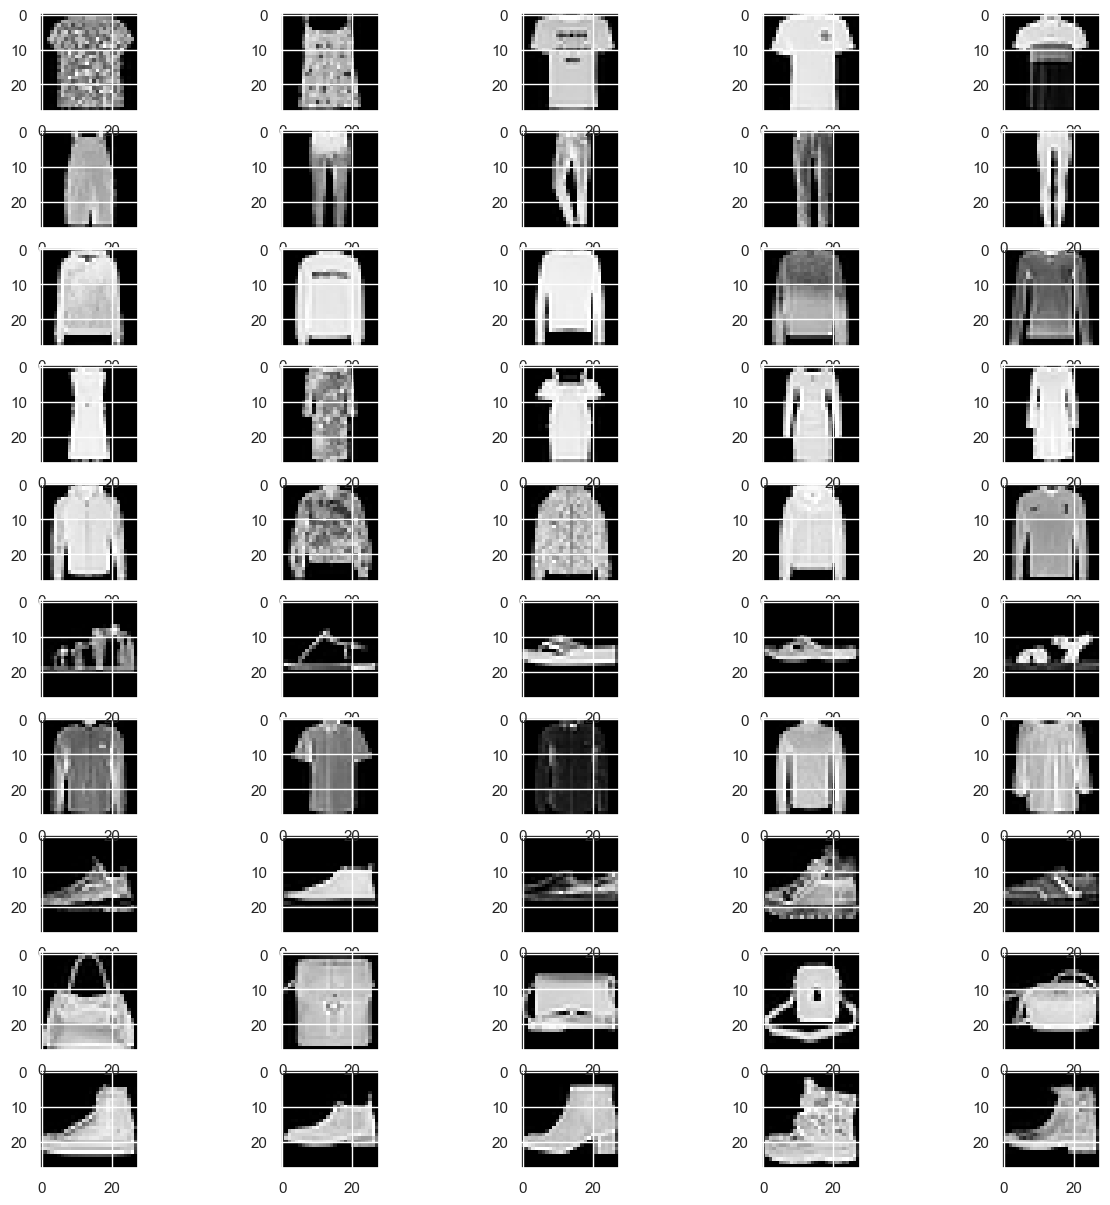

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
)

show_class_images(train_loader, n_images=5)

In [ ]:
# Definir modelo
model_1 = CNN_1().to(device)

# Inicializar componentes de entrenamiento
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=lr)

# Inicializar listas de métricas
history_1 = History()

# Entrenar
for epoch in range(n_epochs):
    train_acc, train_loss = train(model_1, train_loader, loss_fn, optimizer)
    val_acc, val_loss = test(model_1, val_loader, loss_fn)
    history_1.update(train_acc, train_loss, val_acc, val_loss)

    print(f'Epoch [{epoch + 1}/{n_epochs}] | train_loss: {train_loss:.4f}, train_acc: {train_acc:.2f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}')

Epoch [1/20] | train_loss: 0.5299, train_acc: 81.09 | val_loss: 0.3900, val_acc: 85.76


Epoch [2/20] | train_loss: 0.3375, train_acc: 87.81 | val_loss: 0.3520, val_acc: 87.11


Epoch [3/20] | train_loss: 0.2875, train_acc: 89.41 | val_loss: 0.2836, val_acc: 89.83


Epoch [4/20] | train_loss: 0.2549, train_acc: 90.67 | val_loss: 0.2588, val_acc: 90.41


Epoch [5/20] | train_loss: 0.2268, train_acc: 91.59 | val_loss: 0.2610, val_acc: 90.58


Epoch [6/20] | train_loss: 0.2049, train_acc: 92.45 | val_loss: 0.2573, val_acc: 90.44


Epoch [7/20] | train_loss: 0.1886, train_acc: 93.04 | val_loss: 0.2621, val_acc: 90.71


Epoch [8/20] | train_loss: 0.1705, train_acc: 93.76 | val_loss: 0.2495, val_acc: 91.26


Epoch [9/20] | train_loss: 0.1569, train_acc: 94.25 | val_loss: 0.2489, val_acc: 91.49


Epoch [10/20] | train_loss: 0.1419, train_acc: 94.82 | val_loss: 0.2458, val_acc: 91.87


Epoch [11/20] | train_loss: 0.1271, train_acc: 95.37 | val_loss: 0.2497, val_acc: 91.76


Epoch [12/20] | train_loss: 0.1147, train_acc: 95.75 | val_loss: 0.2531, val_acc: 91.67


Epoch [13/20] | train_loss: 0.1046, train_acc: 96.15 | val_loss: 0.2718, val_acc: 91.44


Epoch [14/20] | train_loss: 0.0949, train_acc: 96.47 | val_loss: 0.3202, val_acc: 90.13


Epoch [15/20] | train_loss: 0.0837, train_acc: 96.90 | val_loss: 0.2875, val_acc: 91.37


Epoch [16/20] | train_loss: 0.0739, train_acc: 97.28 | val_loss: 0.3166, val_acc: 91.20


Epoch [17/20] | train_loss: 0.0649, train_acc: 97.63 | val_loss: 0.3283, val_acc: 91.40


Epoch [18/20] | train_loss: 0.0577, train_acc: 97.94 | val_loss: 0.3375, val_acc: 91.66


Epoch [19/20] | train_loss: 0.0511, train_acc: 98.16 | val_loss: 0.3554, val_acc: 91.11


Epoch [20/20] | train_loss: 0.0419, train_acc: 98.56 | val_loss: 0.3629, val_acc: 91.69


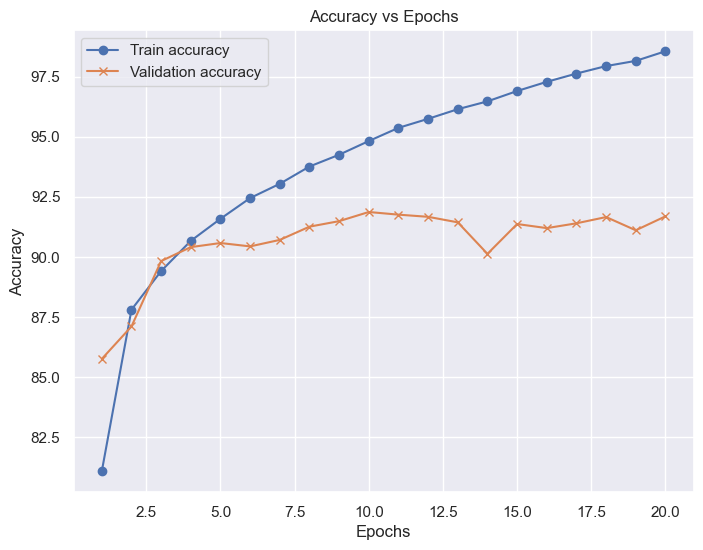

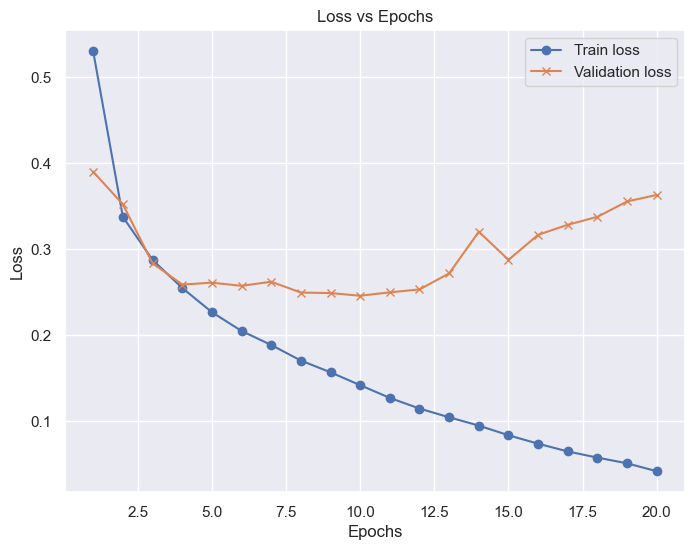

In [ ]:
# Mostrar gráficas de exactitud y pérdida
history_1.plot()
history_1.plot(False)

In [ ]:
torchinfo.summary(model_1, (BATCH_SIZE, 1, *image_size))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_1                                    [100, 10]                 --
├─Conv2d: 1-1                            [100, 16, 28, 28]         160
├─ReLU: 1-2                              [100, 16, 28, 28]         --
├─MaxPool2d: 1-3                         [100, 16, 14, 14]         --
├─Conv2d: 1-4                            [100, 32, 14, 14]         4,640
├─ReLU: 1-5                              [100, 32, 14, 14]         --
├─MaxPool2d: 1-6                         [100, 32, 7, 7]           --
├─Linear: 1-7                            [100, 128]                200,832
├─ReLU: 1-8                              [100, 128]                --
├─Linear: 1-9                            [100, 10]                 1,290
Total params: 206,922
Trainable params: 206,922
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 123.70
Input size (MB): 0.31
Forward/backward pass size (MB): 15.16
Params size (MB): 0.83
Estimated Total

## **Método 2**

In [ ]:
class CNN_2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()
        self.conv_block = nn.Sequential(
            # Capa convolucional 1
            nn.Conv2d(input_shape, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            # Capa convolucional 2
            nn.Conv2d(32, 32, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            # Capa convolucional 3
            nn.Conv2d(32, 32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),

            # Apagar 40% de las neuronas
            nn.Dropout(0.4),

            # Capa convolucional 4
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # Capa convolucional 5
            nn.Conv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # Capa convolucional 6
            nn.Conv2d(64, 64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),

            # Apagar 40% de las neuronas
            nn.Dropout(0.4),

            # Capa convolucional 7
            nn.Conv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.BatchNorm2d(128),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), # Aplanar capa
            nn.Dropout(0.2), # Apagar 20% de las neuronas

            # Capa de salida
            nn.Linear(in_features=128, out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

In [ ]:
BATCH_SIZE = 512
n_epochs = 20
lr = 0.008

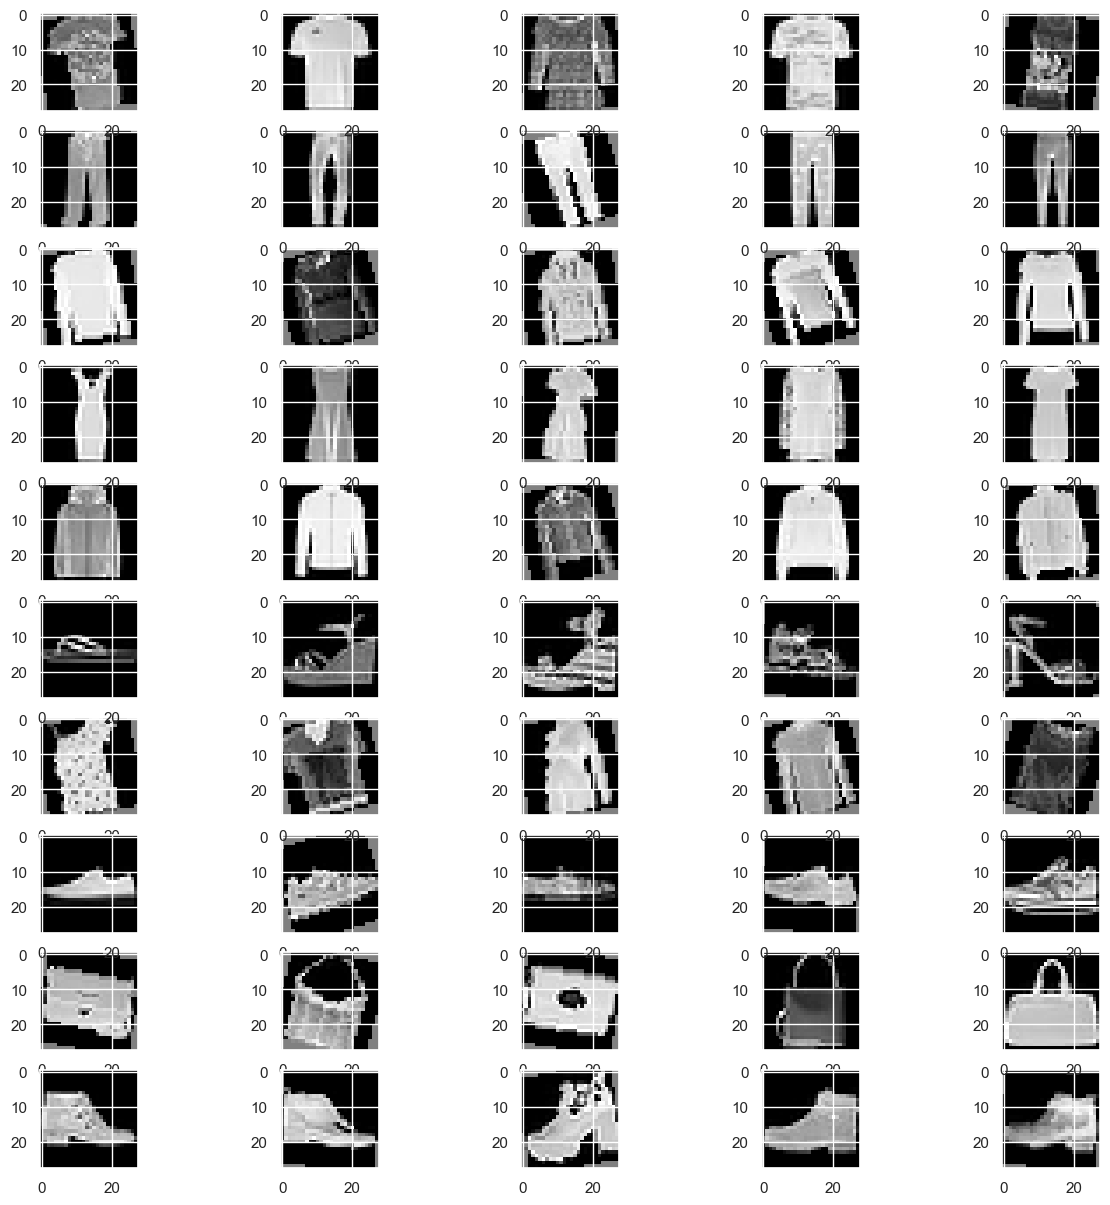

In [ ]:
# Transformación para agregar ruido a los datos
augment_transform = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
    ]
)

# Aumentar datos
augment_train_dataset = AugmentDataset(train_dataset, augment_transform, 2)

train_loader = DataLoader(
    dataset=augment_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
)

show_class_images(train_loader, n_images=5)

In [ ]:
# Definir modelo
model_2 = CNN_2(
    input_shape=1,
    output_shape=N_CLASSES
).to(device)

# Inicializar componentes de entrenamiento
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)

scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=6, gamma=0.5)

# Inicializar listas de métricas
history_2 = History()

# Entrenar
for epoch in range(n_epochs):
    train_acc, train_loss = train(model_2, train_loader, loss_fn, optimizer)
    val_acc, val_loss = test(model_2, val_loader, loss_fn)

    history_2.update(train_acc, train_loss, val_acc, val_loss)
    scheduler.step()

    print(f'Epoch [{epoch + 1}/{n_epochs}] | train_loss: {train_loss:.4f}, train_acc: {train_acc:.2f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.2f}')

Epoch [1/20] | train_loss: 0.5386, train_acc: 79.76 | val_loss: 0.3336, val_acc: 87.52


Epoch [2/20] | train_loss: 0.3604, train_acc: 86.81 | val_loss: 0.2954, val_acc: 89.09


Epoch [3/20] | train_loss: 0.3137, train_acc: 88.52 | val_loss: 0.2759, val_acc: 89.71


Epoch [4/20] | train_loss: 0.2848, train_acc: 89.64 | val_loss: 0.2679, val_acc: 90.09


Epoch [5/20] | train_loss: 0.2658, train_acc: 90.21 | val_loss: 0.2370, val_acc: 91.20


Epoch [6/20] | train_loss: 0.2542, train_acc: 90.70 | val_loss: 0.2344, val_acc: 91.68


Epoch [7/20] | train_loss: 0.2252, train_acc: 91.71 | val_loss: 0.2203, val_acc: 92.23


Epoch [8/20] | train_loss: 0.2130, train_acc: 92.17 | val_loss: 0.2151, val_acc: 92.35


Epoch [9/20] | train_loss: 0.2092, train_acc: 92.31 | val_loss: 0.2171, val_acc: 92.41


Epoch [10/20] | train_loss: 0.2077, train_acc: 92.39 | val_loss: 0.2134, val_acc: 92.35


Epoch [11/20] | train_loss: 0.2030, train_acc: 92.51 | val_loss: 0.2006, val_acc: 92.57


Epoch [12/20] | train_loss: 0.1981, train_acc: 92.65 | val_loss: 0.1985, val_acc: 92.95


Epoch [13/20] | train_loss: 0.1821, train_acc: 93.23 | val_loss: 0.1940, val_acc: 93.17


Epoch [14/20] | train_loss: 0.1750, train_acc: 93.58 | val_loss: 0.1879, val_acc: 93.50


Epoch [15/20] | train_loss: 0.1718, train_acc: 93.59 | val_loss: 0.1922, val_acc: 93.31


Epoch [16/20] | train_loss: 0.1700, train_acc: 93.73 | val_loss: 0.1904, val_acc: 93.24


Epoch [17/20] | train_loss: 0.1668, train_acc: 93.78 | val_loss: 0.1974, val_acc: 93.20


Epoch [18/20] | train_loss: 0.1634, train_acc: 93.93 | val_loss: 0.1929, val_acc: 93.05


Epoch [19/20] | train_loss: 0.1543, train_acc: 94.30 | val_loss: 0.1867, val_acc: 93.39


Epoch [20/20] | train_loss: 0.1501, train_acc: 94.41 | val_loss: 0.1863, val_acc: 93.70


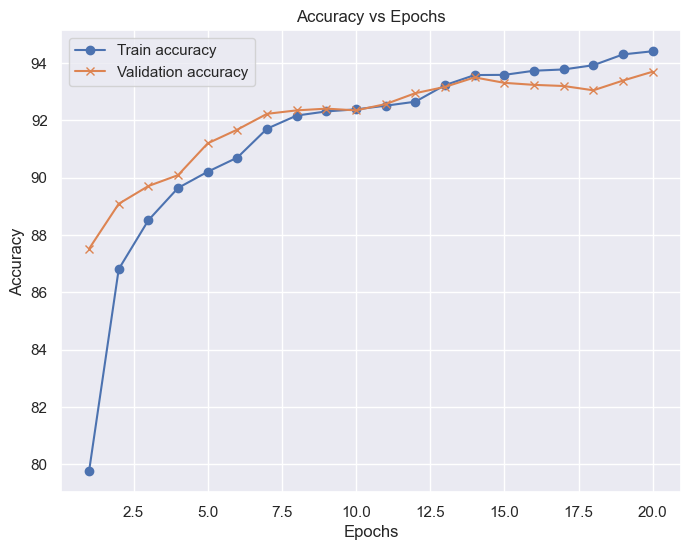

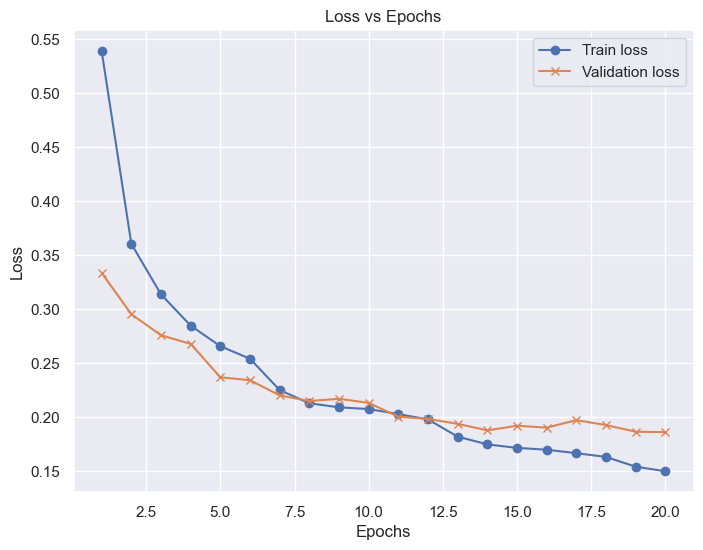

In [ ]:
# Mostrar gráficas de exactitud y pérdida
history_2.plot()
history_2.plot(False)

In [ ]:
torchinfo.summary(model_2, (BATCH_SIZE, 1, *image_size))

Layer (type:depth-idx)                   Output Shape              Param #
CNN_2                                    [512, 10]                 --
├─Sequential: 1-1                        [512, 128, 1, 1]          --
│    └─Conv2d: 2-1                       [512, 32, 26, 26]         320
│    └─ReLU: 2-2                         [512, 32, 26, 26]         --
│    └─BatchNorm2d: 2-3                  [512, 32, 26, 26]         64
│    └─Conv2d: 2-4                       [512, 32, 24, 24]         9,248
│    └─ReLU: 2-5                         [512, 32, 24, 24]         --
│    └─BatchNorm2d: 2-6                  [512, 32, 24, 24]         64
│    └─Conv2d: 2-7                       [512, 32, 11, 11]         25,632
│    └─ReLU: 2-8                         [512, 32, 11, 11]         --
│    └─BatchNorm2d: 2-9                  [512, 32, 11, 11]         64
│    └─Dropout: 2-10                     [512, 32, 11, 11]         --
│    └─Conv2d: 2-11                      [512, 64, 9, 9]           18,496
│  

## **Comparación**

### Modelo 1 ###


              precision    recall  f1-score   support

           0     0.8508    0.8610    0.8559      1000
           1     0.9959    0.9810    0.9884      1000
           2     0.8559    0.8790    0.8673      1000
           3     0.9141    0.9150    0.9145      1000
           4     0.8569    0.8620    0.8594      1000
           5     0.9888    0.9710    0.9798      1000
           6     0.7702    0.7440    0.7569      1000
           7     0.9536    0.9650    0.9592      1000
           8     0.9800    0.9790    0.9795      1000
           9     0.9624    0.9720    0.9672      1000

    accuracy                         0.9129     10000
   macro avg     0.9128    0.9129    0.9128     10000
weighted avg     0.9128    0.9129    0.9128     10000



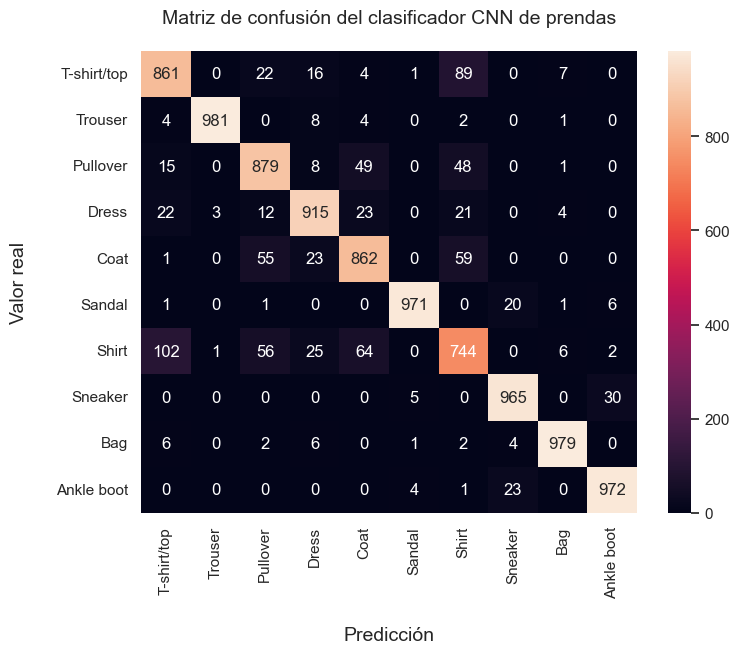

### Modelo 2 ###


              precision    recall  f1-score   support

           0     0.8853    0.8880    0.8867      1000
           1     0.9980    0.9840    0.9909      1000
           2     0.8949    0.9110    0.9029      1000
           3     0.9339    0.9330    0.9335      1000
           4     0.8780    0.9140    0.8956      1000
           5     0.9909    0.9780    0.9844      1000
           6     0.8044    0.7650    0.7842      1000
           7     0.9528    0.9890    0.9706      1000
           8     0.9840    0.9820    0.9830      1000
           9     0.9847    0.9640    0.9742      1000

    accuracy                         0.9308     10000
   macro avg     0.9307    0.9308    0.9306     10000
weighted avg     0.9307    0.9308    0.9306     10000



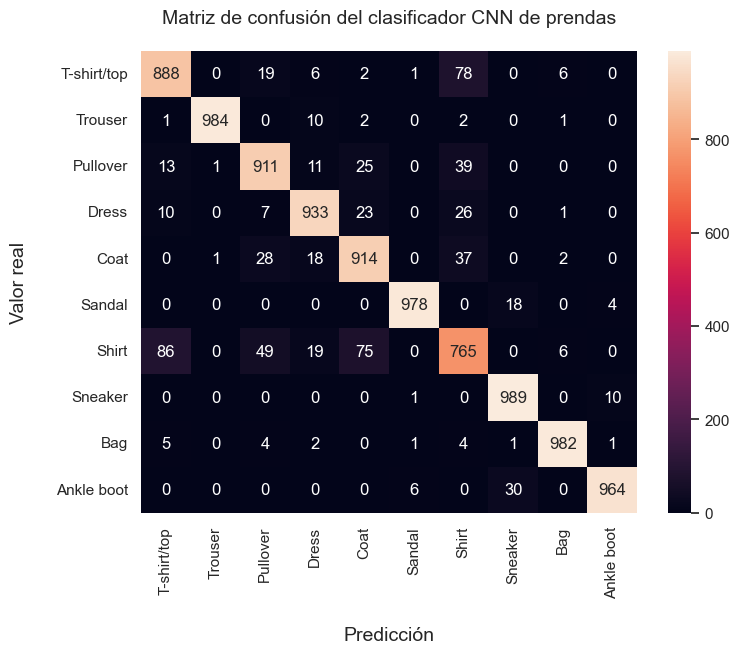

In [ ]:
# Evaluar métricas de los modelos con datos de prueba
print('### Modelo 1 ###')
evaluate(model_1.to(device), test_loader)

print('### Modelo 2 ###')
evaluate(model_2.to(device), test_loader)